<a href="https://colab.research.google.com/github/Ronny5/TSAI_EVA_REPO/blob/master/S7_v7m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assignment 7**

**The Given task was to fix the given model with the below keypoints and improvements.**

1. Fix the network above:
2. change the code such that it uses GPU
3. change the architecture to C1C2C3C40 (basically 3 MPs)
4. total RF must be more than 44
5. one of the layers must use Depthwise Separable Convolution
6. one of the layers must use Dilated Convolution
7. use GAP (compulsory):- add FC after GAP to target #of classes (optional)
8. achieve 80% accuracy, as many epochs as you want. Total Params to be less  than 1M. 
10. upload to Github

**Another task was to modularize the code to a repository in Github**


## **Model Description**

###**Target:** 
80% accuracy with less than 1 million parameters

###**Results:**
Parameters: 733k (<1M)

**Best Train Accuracy:** 83.42

**Best Test Accuracy:** 83.22 (9th Epoch)

**Analysis:** This model has scope of improvement. Dropout and Augumentation was used to avoid overfillting.


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.



###Cloning the GITHUB repository for Session 7 Assignment

In [ ]:
#!rm -rf /content/TSAI_EVA_REPO/

In [ ]:
#%cd ..

/content


In [ ]:
!pwd

/content


In [ ]:
!git clone https://github.com/Ronny5/TSAI_EVA_REPO.git

Cloning into 'TSAI_EVA_REPO'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 115 (delta 50), reused 5 (delta 0), pack-reused 0
Receiving objects: 100% (115/115), 142.95 KiB | 6.50 MiB/s, done.
Resolving deltas: 100% (50/50), done.


### Executing required modules from the Github clone

In [ ]:
import TSAI_EVA_REPO.Utils.s7_utils as util
import TSAI_EVA_REPO.Models.S7_MODEL as model
import TSAI_EVA_REPO.Training.train as trn
import TSAI_EVA_REPO.Testing.test as tst
import TSAI_EVA_REPO.Misc.Misc as misc


### Calculating True Mean and STD for the CIFAR10 dataset (Train & Test combined)

In [ ]:
# Calling the function to calculate the mean and standard deviation for the mentioned dataset

norm_mean, norm_std = util.cifar10_mean_std()
print(norm_mean, norm_std)

Files already downloaded and verified
Files already downloaded and verified
(0.49, 0.48, 0.45) (0.25, 0.24, 0.26)


In [ ]:
train_transform = util.train(norm_mean, norm_std)
test_transform = util.test(norm_mean, norm_std)
print(train_transform, test_transform)

Compose(
    RandomRotation(degrees=(-5.0, 5.0), resample=False, expand=False, fill=(1, 1, 1))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.49, 0.48, 0.45), std=(0.25, 0.24, 0.26))
) Compose(
    ToTensor()
    Normalize(mean=(0.49, 0.48, 0.45), std=(0.25, 0.24, 0.26))
)


In [ ]:
# Extract and transform the data

train_set = trn.s7train(train_transform)
test_set  = tst.test(test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Dataloader Arguments & Test/Train Dataloaders - Loading into the GPU
import torch
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
    
# dataloader arguments 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64, num_workers=1)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)
# test dataloader
test_loader  = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


airplane   dog  deer  deer


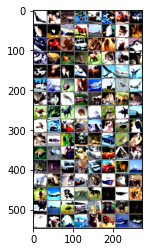

In [ ]:
misc.samplegrid(train_loader,classes)

### Defining a Deep Convolution NN



In [ ]:
# from torchsummary import summary

import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
models = model.s7netv1().to(device)
summary(models, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
             ReLU-14           [-1

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when we start your training loop, ideally we should zero out the gradients so that we do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(models.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(models, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(models, device, test_loader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.1052119731903076 Batch_id=390 Train Accuracy=44.91: 100%|██████████| 391/391 [00:28<00:00, 13.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2649, Test Accuracy: 5415/10000 (54.15%)

EPOCH: 1


Loss=0.7609341144561768 Batch_id=390 Train Accuracy=61.40: 100%|██████████| 391/391 [00:28<00:00, 13.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1193, Test Accuracy: 6204/10000 (62.04%)

EPOCH: 2


Loss=0.7325268983840942 Batch_id=390 Train Accuracy=68.90: 100%|██████████| 391/391 [00:28<00:00, 13.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8406, Test Accuracy: 7037/10000 (70.37%)

EPOCH: 3


Loss=0.7054497599601746 Batch_id=390 Train Accuracy=72.74: 100%|██████████| 391/391 [00:28<00:00, 13.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7305, Test Accuracy: 7452/10000 (74.52%)

EPOCH: 4


Loss=0.5994943380355835 Batch_id=390 Train Accuracy=75.50: 100%|██████████| 391/391 [00:29<00:00, 13.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6547, Test Accuracy: 7747/10000 (77.47%)

EPOCH: 5


Loss=0.6192374229431152 Batch_id=390 Train Accuracy=77.43: 100%|██████████| 391/391 [00:29<00:00, 13.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6312, Test Accuracy: 7854/10000 (78.54%)

EPOCH: 6


Loss=0.4910368025302887 Batch_id=390 Train Accuracy=81.51: 100%|██████████| 391/391 [00:29<00:00, 13.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5291, Test Accuracy: 8209/10000 (82.09%)

EPOCH: 7


Loss=0.5962218046188354 Batch_id=390 Train Accuracy=82.54: 100%|██████████| 391/391 [00:29<00:00, 13.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5140, Test Accuracy: 8243/10000 (82.43%)

EPOCH: 8


Loss=0.4498482644557953 Batch_id=390 Train Accuracy=83.11: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5122, Test Accuracy: 8249/10000 (82.49%)

EPOCH: 9


Loss=0.4787677824497223 Batch_id=390 Train Accuracy=83.42: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]



Test set: Average loss: 0.4984, Test Accuracy: 8322/10000 (83.22%)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile  ship  bird  deer


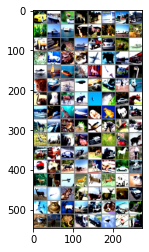

In [ ]:
misc.samplegrid(test_loader,classes)

In [ ]:
outputs = models(images.to(device))
outputs.shape

torch.Size([128, 10])

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship   cat  deer  deer


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = models(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 83 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = models(data)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == target).squeeze()
        for i in range(4):
            label = target[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 88 %
Accuracy of automobile : 96 %
Accuracy of  bird : 60 %
Accuracy of   cat : 63 %
Accuracy of  deer : 80 %
Accuracy of   dog : 67 %
Accuracy of  frog : 83 %
Accuracy of horse : 85 %
Accuracy of  ship : 100 %
Accuracy of truck : 82 %
